## Natural Language Processing (S1-24_AIMLCZG530)
**Assignment-2-PS-F: BERT (Bidirectional Encoder Representations from Transformers) for Social Media Sentiment Analysis.**

### Group ID: 203
### Group Members Name with Student ID:
1. Aishwarya R - 2023AC05647 - 100% contribution
2. PATIL NIKETAN MANGESH RAJANI 2023AD05009- 100% contribution
3. PEDDIBHOTLA MRUGAANK SHIRISHKUMAR (2023AC05957) - 100% contribution
4. PRABHAT DAS (2023AC05037) - 100% contribution
5. Mylavarapu Venkata Krishna - 2023AC05601 - 100% contribution

### Import necessary packages

In [1]:

# Importing Standard Libraries
import random
import re
import string
import numpy as np
import pandas as pd
import emoji

# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

# Importing PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# Importing Transformer and NLP Libraries
from transformers import BertTokenizer, BertModel
import gensim.downloader as api
import spacy
import nltk
from nltk.corpus import stopwords, opinion_lexicon

# Importing Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Downloading necessary datasets (uncomment if needed)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("opinion_lexicon")
spacy.cli.download("en_core_web_sm")

# Setting Seed for Reproducibility
seed = 42  # Any fixed number for consistency
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aishk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aishk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\aishk\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Data Preparation

This section processes the sentiment dataset by removing duplicates, handling missing values, and mapping sentiment labels using both an automated approach and a custom classification method.  

#### Steps Performed:

1. **Load the Dataset**  
   - Read the CSV file containing text and sentiment labels.  
   - Remove duplicate rows and handle missing values to clean the dataset.  

2. **Extract and Analyze Sentiment Labels**  
   - Identify unique sentiment labels in the dataset.  
   - Compare them with predefined positive and negative words from the NLTK opinion lexicon.  
   - Identify words that are not found in the lexicon.  

3. **Automatically Classify Sentiments**  
   - Use the NLTK opinion lexicon to classify known words as Positive or Negative.  
   - Assign "Neutral" to words that are not found in the lexicon.  

4. **Manually Classify Missing Words**  
   - Create a custom sentiment dictionary for words not covered by the lexicon.  
   - Assign sentiment labels (Positive, Negative, or Neutral) based on context.  

5. **Apply Sentiment Classification**  
   - First, classify sentiment labels using the lexicon.  
   - Then, apply the custom dictionary for words that were not found.  

6. **Convert Sentiment Labels to Numeric Values**  
   - Map sentiment categories to numerical values:  
     - Negative → `0`  
     - Neutral → `1`  
     - Positive → `2`  

7. **Check for Any Unclassified Words**  
   - Identify any words that remain unclassified.  
   - Print the count of such words to ensure proper coverage.  

By following these steps, the dataset is cleaned, labeled, and ready for further analysis or model training.

In [2]:
# Loading the dataset
df = pd.read_csv(r"E:\Aish's Office\Mtech\assignments\NLP\assignment2\sentimentdataset.csv")

# Check for duplicate values
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicate rows
df = df.drop_duplicates()

# Check for missing (null) values
null_counts = df.isnull().sum()
print(f"Missing values per column:\n{null_counts}")

# Drop rows with null values
df = df.dropna()

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Print final dataset size
print(f"Final dataset size after cleaning: {df.shape}")

# Importing sentiment words from NLTK's opinion lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Checking for words that are not in the opinion lexicon
all_sentiments = set(df["Sentiment"].str.lower().str.strip().unique())
missing_words = all_sentiments - (positive_words | negative_words)

print(f"{len(missing_words)} words are not found in the opinion lexicon:")
print(missing_words)  # Display words that are not present in the lexicon

# Creating a custom sentiment dictionary for words that are missing
custom_sentiment_map = {
    "motivation": "Positive", "thrilling journey": "Positive", "exploration": "Positive",
    "empathetic": "Positive", "nostalgia": "Neutral", "contemplation": "Neutral",
    "iconic": "Positive", "heartache": "Negative", "numbness": "Negative",
    "positivity": "Positive", "bittersweet": "Neutral", "dreamchaser": "Positive",
    "pensive": "Neutral", "mindfulness": "Positive", "emotion": "Neutral",
    "whispers of the past": "Neutral", "heartbreak": "Negative", "captivation": "Positive",
    "pressure": "Negative", "enchantment": "Positive", "amusement": "Positive",
    "renewed effort": "Positive", "yearning": "Neutral", "adoration": "Positive",
    "vibrancy": "Positive", "hypnotic": "Positive", "inspired": "Positive",
    "challenge": "Neutral", "emotionalstorm": "Negative", "appreciation": "Positive",
    "immersion": "Positive", "embarrassed": "Negative", "determination": "Positive",
    "solitude": "Neutral", "connection": "Positive", "anticipation": "Positive",
    "blessed": "Positive", "adrenaline": "Positive", "romance": "Positive",
    "arousal": "Positive", "reflection": "Neutral", "playfuljoy": "Positive",
    "winter magic": "Positive", "creative inspiration": "Positive",
    "acceptance": "Positive", "coziness": "Positive", "wonderment": "Positive",
    "festivejoy": "Positive", "friendship": "Positive", "whimsy": "Positive",
    "journey": "Neutral", "sympathy": "Positive", "joy in baking": "Positive",
    "free-spirited": "Positive", "energy": "Positive", "imagination": "Positive",
    "celestial wonder": "Positive", "neutral": "Neutral", "engagement": "Positive",
    "joyfulreunion": "Positive", "satisfaction": "Positive", "hope": "Positive",
    "kind": "Positive", "surprise": "Positive", "culinary adventure": "Positive",
    "ocean's freedom": "Positive", "rejuvenation": "Positive", "melodic": "Positive",
    "touched": "Positive", "suspense": "Negative", "envisioning history": "Neutral",
    "lostlove": "Negative", "adventure": "Positive", "creativity": "Positive",
    "spark": "Positive", "resilience": "Positive", "artisticburst": "Positive",
    "curiosity": "Positive", "innerjourney": "Positive", "nature's beauty": "Positive",
    "culinaryodyssey": "Positive", "runway creativity": "Positive"
}

# Function to classify sentiment based on the lexicon and custom mapping
def classify_sentiment(sentiment):
    sentiment = sentiment.lower().strip()  # Convert to lowercase and remove extra spaces

    # Check if the word is in the custom sentiment dictionary
    if sentiment in custom_sentiment_map:
        return custom_sentiment_map[sentiment]
    
    # Check if the word exists in the opinion lexicon
    if sentiment in positive_words:
        return "Positive"
    elif sentiment in negative_words:
        return "Negative"
    else:
        return "Neutral"  # Default label for unknown words

# Applying the sentiment classification function to the dataset
df["Sentiment_Category"] = df["Sentiment"].apply(classify_sentiment)

# Mapping sentiment categories to numerical values for further analysis
df["Sentiment_Label"] = df["Sentiment_Category"].map({"Negative": 0, "Neutral": 1, "Positive": 2})

# Checking if any words are still not classified
unclassified_words = all_sentiments - set(custom_sentiment_map.keys()) - positive_words - negative_words

print(f"Remaining words that are not mapped: {len(unclassified_words)}")
print(unclassified_words)  # Should be empty if all words have been classified


Number of duplicate rows: 0
Missing values per column:
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64
Final dataset size after cleaning: (732, 15)
82 words are not found in the opinion lexicon:
{'sympathy', 'contemplation', 'nostalgia', 'winter magic', 'acceptance', 'envisioning history', 'iconic', 'melodic', 'free-spirited', 'hypnotic', 'anticipation', 'coziness', 'mindfulness', 'challenge', "ocean's freedom", 'amusement', 'engagement', 'neutral', 'creativity', 'arousal', 'friendship', 'adrenaline', 'motivation', 'enchantment', 'hope', 'surprise', 'empathetic', 'suspense', 'vibrancy', 'numbness', 'romance', 'determination', 'heartbreak', 'adoration', 'bittersweet', 'pressure', 'whispers of the past', 'connection', 'spark', 'culinaryodyssey', 'creative i

## Data Preprocessing

This section focuses on cleaning text data and converting it into a structured dataset for sentiment analysis.  

#### Steps Performed:  

1. Load the NLP Model and Stopwords  
   - Load SpaCy's English language model for text processing.  
   - Load a list of English stopwords from NLTK to help remove unnecessary words.  

2. Define Regular Expressions for Text Cleaning  
   - Precompile regex patterns to remove:  
     - URLs  
     - HTML tags  
     - Punctuation  
     - Non-ASCII characters  
     - Numbers  
     - Extra spaces  

3. Create a Function to Clean Text  
   - Convert text to lowercase for uniformity.  
   - Convert emojis to text format to retain meaning.  
   - Apply regex patterns to remove unwanted elements.  
   - Ensure cleaned text has no extra spaces or unnecessary symbols.  

4. Apply Cleaning Function to the Dataset  
   - Handle missing values by replacing NaN with empty strings.  
   - Apply clean_text() function to the text column in the dataset.  

5. Define the SentimentDataset Class  
   - Convert the DataFrame into a dataset class that can be used for model training.  
   - Store text and sentiment labels as a list of tuples.  
   - Define methods to retrieve samples and get dataset length.  

6. Convert the DataFrame into a Dataset Object  
   - Create an instance of SentimentDataset to structure the cleaned text and sentiment labels for training.  

This ensures the text is properly cleaned and formatted as a dataset for further processing in the sentiment analysis model.

In [3]:
# Loading the NLP model and stopwords
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Load SpaCy model without unnecessary components
stop_words = set(stopwords.words("english"))  # Load English stopwords

# Precompile regular expressions for faster text cleaning
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")  # Remove URLs
HTML_PATTERN = re.compile(r"<.*?>+")  # Remove HTML tags
PUNCTUATION_PATTERN = re.compile(rf"[{re.escape(string.punctuation)}]")  # Remove punctuation
EXTRA_SPACES_PATTERN = re.compile(r"\s+")  # Remove extra spaces
NON_ASCII_PATTERN = re.compile(r"[^\x00-\x7F]+")  # Remove non-ASCII characters
BRACKETS_PATTERN = re.compile(r"\[.*?\]")  # Remove content inside brackets
NUMBERS_PATTERN = re.compile(r"\b\d+\b")  # Remove standalone numbers

def clean_text(text):
    """
    Function to clean text by removing unwanted elements.
    """
    if not isinstance(text, str):
        return ""  # Return empty string if input is not valid text
    
    text = text.lower()  # Convert text to lowercase
    text = emoji.demojize(text)  # Convert emojis to their text representation

    # Apply regex patterns to remove unwanted elements
    text = URL_PATTERN.sub("", text)  # Remove URLs
    text = HTML_PATTERN.sub("", text)  # Remove HTML tags
    text = BRACKETS_PATTERN.sub("", text)  # Remove bracketed content
    text = PUNCTUATION_PATTERN.sub("", text)  # Remove punctuation
    text = NUMBERS_PATTERN.sub("", text)  # Remove numbers
    text = NON_ASCII_PATTERN.sub("", text)  # Remove non-ASCII characters
    text = EXTRA_SPACES_PATTERN.sub(" ", text.strip())  # Remove extra spaces and trim text

    return text

# Apply the cleaning function to the text column in the dataset
df["Text"] = df["Text"].fillna("")  # Replace NaN with an empty string
df["Text"] = df["Text"].apply(clean_text)


In [4]:
# Define SentimentDataset Class
class SentimentDataset:
    def __init__(self, df):
        self.data = list(zip(df["Text"].tolist(), df["Sentiment_Label"].tolist()))

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

# Convert DataFrame to SentimentDataset
dataset = SentimentDataset(df)

### Data Vizualization

This section focuses on generating various visualizations to explore the dataset, including word clouds, sentence length distributions, and sentiment distributions.

#### Steps Performed:

1. **Clean Sentiment Column and Generate a Sentiment Word Cloud**  
   - Remove unnecessary spaces from the sentiment labels.  
   - Create a word cloud to visualize the frequency of sentiment categories (Positive, Neutral, Negative).  

2. **Analyze Sentence Lengths**  
   - Compute the number of words in each sentence.  
   - Plot a histogram to show the distribution of sentence lengths using pastel colors.  

3. **Generate a Word Cloud for Common Words in Text**  
   - Combine all text data into a single string.  
   - Create a word cloud to highlight the most frequently used words in the dataset.  

4. **Visualize Sentiment Distribution**  
   - Extract sentiment labels from the dataset.  
   - Use a bar plot to display the distribution of sentiment classes (Negative, Neutral, Positive) with pastel shades.  

These visualizations help in understanding the dataset's structure and sentiment composition before model training.

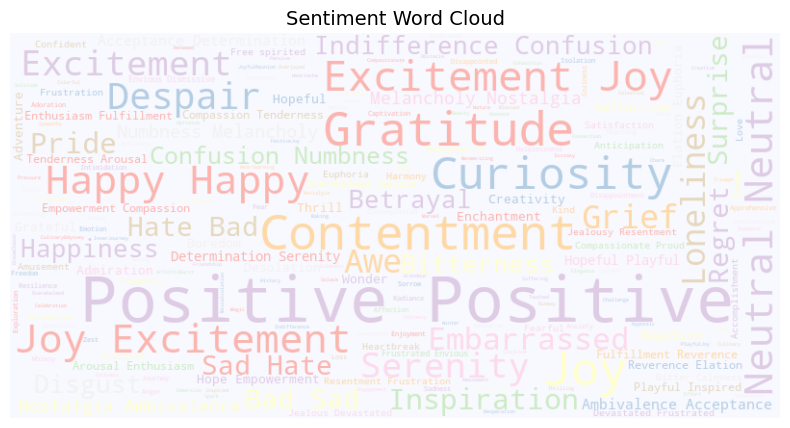

In [5]:
# Ensure 'Sentiment' and 'Text' columns are cleaned
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()

# Extract sentiment-based words
sentiment_text = " ".join(df["Sentiment"])  # Get all sentiment labels as text

# Generate word cloud using sentiment words
wordcloud = WordCloud(
    width=800, height=400, background_color="#f8f8ff", colormap="Pastel1"
).generate(sentiment_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Sentiment Word Cloud", fontsize=14)
plt.show()


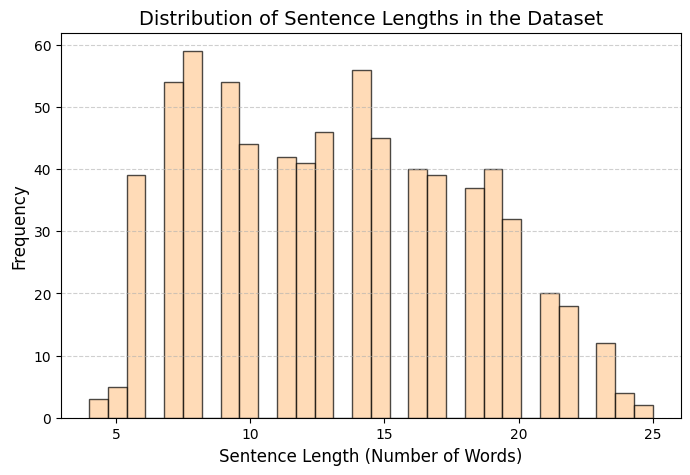

In [6]:
# Compute sentence lengths (counting words in each sentence)
sentence_lengths = [len(sentence.split()) for sentence, _ in dataset.data]

# Plot histogram of sentence lengths with pastel colors
plt.figure(figsize=(8,5))
plt.hist(sentence_lengths, bins=30, edgecolor="black", color="#ffcc99", alpha=0.7)
plt.xlabel("Sentence Length (Number of Words)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Sentence Lengths in the Dataset", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

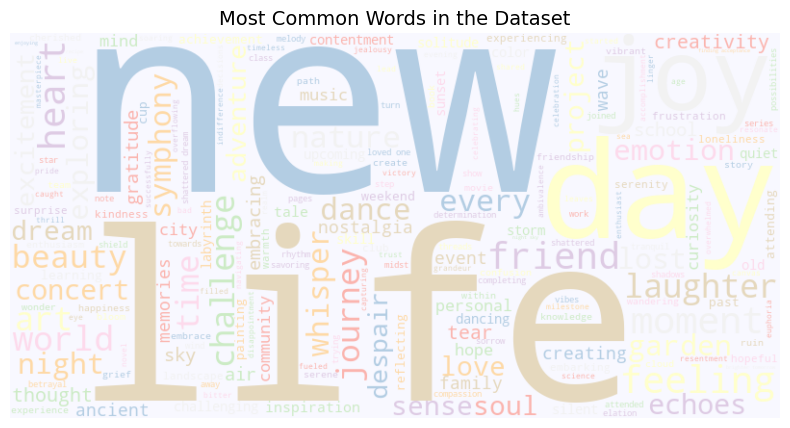

In [7]:
# Combine all text data
all_text = " ".join(sentence for sentence, _ in dataset.data)

# Generate word cloud with pastel background
wordcloud = WordCloud(width=800, height=400, background_color="#f8f8ff", colormap="Pastel1").generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in the Dataset", fontsize=14)
plt.show()


C:\Users\aishk\AppData\Local\Temp\ipykernel_19596\3374424810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette=pastel_palette)


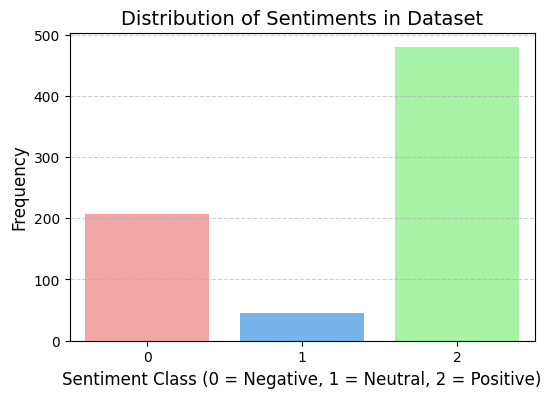

In [ ]:
# Extract sentiment labels
labels = [label for _, label in dataset.data]

# Define pastel color palette
pastel_palette = ["#ff9999", "#66b3ff", "#99ff99"]  

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=labels, palette=pastel_palette)
plt.xlabel("Sentiment Class (0 = Negative, 1 = Neutral, 2 = Positive)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Sentiments in Dataset", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


### Model Building

Splitting the dataset into training, validation, and test sets. 
Stratification is used to maintain the proportion of sentiment labels in each set

In [9]:
# Split Data into Training (70%) and Temporary (30%) Set
train_data, temp_data = train_test_split(
    dataset.data, test_size=0.3, stratify=[label for _, label in dataset.data], random_state=42
)

# Split Temporary Data into Validation (15%) and Test (15%)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, stratify=[label for _, label in temp_data], random_state=42
)

#  Unpack Text (X) and Labels (y)
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert Labels to PyTorch Tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Ensure X Variables are Lists
X_train, X_val, X_test = list(X_train), list(X_val), list(X_test)

# Print Dataset Sizes
print(f"Train Size: {len(X_train)} ({(len(X_train)/len(dataset.data)) * 100:.2f}%)")
print(f"Validation Size: {len(X_val)} ({(len(X_val)/len(dataset.data)) * 100:.2f}%)")
print(f"Test Size: {len(X_test)} ({(len(X_test)/len(dataset.data)) * 100:.2f}%)")

Train Size: 512 (69.95%)
Validation Size: 110 (15.03%)
Test Size: 110 (15.03%)


This section loads pretrained embeddings (BERT and GloVe) and prepares the text data for model training.

#### Steps Performed:

1. **Load Pretrained Models**  
   - Load the BERT tokenizer and model for sentence embeddings.  
   - Load GloVe embeddings

2. **Create Word Index Mapping for GloVe**  
   - Assign an index to each word in the GloVe vocabulary.  
   - Add special tokens <PAD> for padding and <UNK> for unknown words).  
   - Create an index-to-word mapping for reference.

3. **Build an Embedding Matrix for GloVe**  
   - Initialize an empty matrix.  
   - Fill it with pretrained GloVe vectors for known words.  
   - Assign random values for unknown words.

4. **Convert Text to Numerical Sequences**  
   - Define a function to convert text into word indices using GloVe.  
   - Truncate longer sequences to a fixed length.

5. **Move BERT Model to GPU (if available)**  
   - Check for GPU availability and transfer the model to the appropriate device.

6. **Generate Embeddings for Text Data**  
   - For BERT: Convert text into embeddings using the pretrained model.  
   - For GloVe: Convert text into sequences of word indices using the word mapping.  
   - Store embeddings for training, validation, and test sets.

7. **Define LSTM-based Sentiment Model**  
   - Create an LSTM model with optional GloVe embedding support.  
   - Use bidirectional LSTMs with dropout for better performance.  
   - Apply a fully connected layer to predict sentiment labels.

8. **Implement a Collate Function for DataLoader**  
   - Handle variable-length sequences by padding them properly.  
   - Convert text, sequence lengths, and labels into tensors.

This setup ensures that both BERT and GloVe are ready for training a sentiment analysis model.

In [10]:
# Load Pretrained Models for Text Embeddings
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Load BERT tokenizer
bert_model = BertModel.from_pretrained("bert-base-uncased")  # Load BERT model
glove_model = api.load("glove-wiki-gigaword-100")  # Load GloVe word embeddings (100D)

# Create word-to-index and index-to-word mapping for GloVe
glove_vocab = glove_model.index_to_key  # Get the vocabulary from GloVe
word2idx = {word: idx + 1 for idx, word in enumerate(glove_vocab)}  # Assign indices (start from 1)
word2idx["<PAD>"] = 0  # Padding token
word2idx["<UNK>"] = len(word2idx)  # Unknown word token
idx2word = {idx: word for word, idx in word2idx.items()}  # Reverse mapping (index to word)

# Create Embedding Matrix for GloVe
embedding_dim = 100  # GloVe embedding size
vocab_size = len(word2idx)

# Initialize matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill matrix with GloVe vectors
for word, idx in word2idx.items():
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]  # Assign pretrained vector
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Assign random vector for unknown words

# Function to convert text into a sequence of word indices (for GloVe)
def text_to_sequence(text, max_length=128):
    sequence = [word2idx.get(word, word2idx["<UNK>"]) for word in text.split()]
    return torch.tensor(sequence[:max_length])  # Truncate if too long

# Move BERT model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Function to get BERT embeddings for sentences
def get_bert_embeddings(sentences):
    sentences = [str(s) for s in sentences]  # Ensure all inputs are strings
    inputs = bert_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)  # Get BERT output

    embeddings = outputs.last_hidden_state  # Extract the full sequence embeddings
    lengths = torch.tensor([embeddings.shape[1]] * embeddings.shape[0], dtype=torch.long).to(device)
    return embeddings, lengths  # Output embeddings and sequence lengths

# Function to get GloVe embeddings
def get_glove_embeddings(sentences, max_length=128):
    indexed_sequences = [text_to_sequence(text, max_length) for text in sentences]
    indexed_sequences = pad_sequence(indexed_sequences, batch_first=True).to(device)  # Pad sequences
    lengths = torch.tensor([len(seq) for seq in indexed_sequences], dtype=torch.long).to(device)
    return indexed_sequences, lengths  # Output token indices and sequence lengths

# Convert training, validation, and test text data to embeddings
bert_train_emb, bert_train_lengths = get_bert_embeddings(X_train)  
bert_val_emb, bert_val_lengths = get_bert_embeddings(X_val)
bert_test_emb, bert_test_lengths = get_bert_embeddings(X_test)

glove_train_emb, glove_train_lengths = get_glove_embeddings(X_train) 
glove_val_emb, glove_val_lengths = get_glove_embeddings(X_val)
glove_test_emb, glove_test_lengths = get_glove_embeddings(X_test)

# Define LSTM Model for Sentiment Analysis (with GloVe support)
class NLP_Sentiment_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3, num_layers=2, use_glove=False):
        super(NLP_Sentiment_Model, self).__init__()

        self.use_glove = use_glove  # Flag to indicate whether to use GloVe embeddings

        if use_glove:
            # Load pretrained GloVe embeddings
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
            input_dim = embedding_dim  # Ensure input dimension matches GloVe embedding size
        
        # Define LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Fully connected output layer

    def forward(self, inputs, lengths):
        if self.use_glove:
            inputs = self.embedding(inputs)  # Convert indices to embeddings

        # Pack the sequences for LSTM processing
        packed_emb = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_emb)
        
        # Concatenate the last forward and backward hidden states
        hidden_output = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden_output = self.dropout(hidden_output)
        return self.fc(hidden_output)  # Output sentiment scores

# Collate function for DataLoader (handles different sequence lengths)
def collate_batch(batch):
    batch_emb, batch_lengths, batch_labels = zip(*batch)

    # Convert lists to tensors and pad sequences
    batch_emb = pad_sequence(batch_emb, batch_first=True, padding_value=word2idx["<PAD>"]).to(device)
    batch_lengths = torch.tensor(batch_lengths, dtype=torch.long).to(device)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

    return batch_emb, batch_lengths, batch_labels


### Model Training and Evaluation Function

This section defines functions to train and evaluate the sentiment analysis model while addressing class imbalance and optimizing learning.  

**Train Model Function**

Prepare Data for Training  
- Convert training and validation embeddings into PyTorch datasets.  
- Use a DataLoader to efficiently load data in batches.  

Set Up Model and Optimization  
- Move the model to the correct device (CPU/GPU).  
- Handle class imbalance by computing class weights dynamically. Class imbalance can lead to biased predictions, favoring majority classes. To mitigate this, class weights are computed and passed to the loss function, ensuring that underrepresented classes contribute more.  
- Use CrossEntropyLoss with the computed class weights to balance training.  
- Use AdamW optimizer instead of standard Adam to improve weight decay handling and prevent overfitting.  
- Apply a learning rate scheduler to dynamically reduce the learning rate when validation loss stagnates. If the validation loss does not improve for multiple consecutive epochs, the learning rate is reduced to fine-tune training.  

Training Loop  
- Train the model for a fixed number of epochs.  
- Perform a forward pass, compute loss, backpropagate, and update weights.  
- Gradient clipping is applied to prevent exploding gradients.  

Validation Step  
- Evaluate the model on the validation set after each epoch.  
- Compute validation loss and accuracy.  
- Adjust the learning rate if the validation loss does not improve.  

Early Stopping  
- Monitor validation loss throughout training.  
- Save the model whenever validation loss improves.  
- If the loss does not improve for multiple epochs, training stops early to prevent overfitting.  

**Evaluate Model Function**
- Load the test dataset into a DataLoader.  
- Run the model in evaluation mode without training.  
- Use 32 epochs for testing
- Compute predictions and compare them with actual labels.  
- Calculate accuracy, precision, recall, and F1-score to measure performance.  
- Print the evaluation results.  

By implementing class weighting, AdamW optimization, dynamic learning rate scheduling, and early stopping, the model is trained efficiently, prevents overfitting, and performs well on unseen data.  


In [11]:
# Function to train the model
def train_model(model, train_data, val_data, epochs=40, lr=1e-4, batch_size=64, patience=15):
    train_emb, train_lengths, train_labels = train_data
    val_emb, val_lengths, val_labels = val_data

    train_dataset = TensorDataset(train_emb, train_lengths, train_labels)
    val_dataset = TensorDataset(val_emb, val_lengths, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    model.to(device)

    class_weights = compute_class_weight("balanced", classes=np.unique(train_labels.cpu()), y=train_labels.cpu().numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, verbose=True)

    best_val_loss = float("inf")
    patience_counter = 0  

    #  Lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, all_preds, all_labels = 0, [], []

        for batch_emb, batch_lengths, batch_labels in train_loader:
            batch_emb, batch_lengths, batch_labels = batch_emb.to(device), batch_lengths.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            logits = model(batch_emb, batch_lengths)
            loss = criterion(logits, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(logits.argmax(dim=1).tolist())
            all_labels.extend(batch_labels.tolist())

        avg_train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)

        # Store training loss & accuracy
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_preds, val_labels_list = 0, [], []

        with torch.no_grad():
            for batch_emb, batch_lengths, batch_labels in val_loader:
                batch_emb, batch_lengths, batch_labels = batch_emb.to(device), batch_lengths.to(device), batch_labels.to(device)

                logits = model(batch_emb, batch_lengths)
                loss = criterion(logits, batch_labels)
                val_loss += loss.item()
                val_preds.extend(logits.argmax(dim=1).tolist())
                val_labels_list.extend(batch_labels.tolist())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels_list, val_preds)

        # Store validation loss & accuracy
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early Stopping Condition
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  
        else:
            patience_counter += 1  

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  

    #  Return training history for visualization
    return train_losses, val_losses, train_accs, val_accs


# Function to evaluate the model on test data
def evaluate_model(model, embeddings, lengths, labels):
    model.eval()  
    dataset = TensorDataset(embeddings, lengths, labels)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_emb, batch_lengths, batch_labels in loader:
            batch_emb, batch_lengths, batch_labels = batch_emb.to(device), batch_lengths.to(device), batch_labels.to(device)
            logits = model(batch_emb, batch_lengths)  
            preds = logits.argmax(dim=1).cpu()  
            all_preds.extend(preds.tolist())
            all_labels.extend(batch_labels.cpu().tolist())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    #  Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, 
                xticklabels=["Negative", "Neutral", "Positive"], 
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



### Model Training and Evaluation

This section focuses on training sentiment analysis models using BERT and GloVe embeddings, tracking their performance, and visualizing results, including early stopping mechanisms.

#### Steps Performed  

1. Define a Function to Plot Training Progress  
   - Plots training vs. validation loss to monitor model convergence.  
   - Plots training vs. validation accuracy to assess model performance.  

2. Train and Evaluate Model Using BERT Embeddings  
   - Initialize a BERT-based model with a hidden dimension of 512 and dropout of 0.3.  
   - Train the model for 40 epochs with a learning rate of 3e-5.  
   - Implement early stopping with patience of 10 to prevent overfitting if validation loss stops improving.  
   - Store training loss, validation loss, training accuracy, and validation accuracy for visualization.  
   - Plot the training and validation curves to analyze model behavior.  
   - Evaluate the trained model on the test set and generate a confusion matrix to measure classification performance.  

3. Train and Evaluate Model Using GloVe Embeddings  
   - Initialize a GloVe-based model with 384 hidden units and dropout of 0.5.  
   - Train the model for 40 epochs with a learning rate of 1.5e-4.  
   - Apply early stopping with patience of 10 to halt training if no improvement is observed.  
   - Track training and validation metrics and visualize the learning curves.  
   - Evaluate the model on the test set and display a confusion matrix to analyze performance.  

This ensures both BERT and GloVe models are trained efficiently with early stopping to avoid overfitting, and their learning progress is visualized for better insights.

#### Hyperparameter Justification

Choosing the right hyperparameters is crucial for optimizing model performance while preventing overfitting. Below are the justifications for the selected hyperparameters:

Learning Rate 
- BERT: A lower learning rate (`3e-5`) is chosen since fine-tuning transformer models requires small updates to avoid catastrophic forgetting.
- GloVe: A slightly higher learning rate (`1.5e-4`) is used because GloVe embeddings are static, and the LSTM model needs to learn representations from scratch.

Dropout 
- BERT: `0.3` dropout helps prevent overfitting while retaining enough network capacity to leverage contextual embeddings.
- GloVe: A higher dropout (`0.5`) is used as LSTMs are prone to overfitting due to sequential dependencies.

Hidden Dimension 
- BERT: `512` hidden units allow for richer feature extraction while maintaining computational efficiency.
- GloVe: `384` hidden units are used to balance performance and resource consumption.

Number of Layers 
- Using `2` layers in LSTM ensures better feature extraction from sequential data while avoiding vanishing gradient issues.

Batch Size 
- BERT: A batch size of `32` is chosen as it balances memory usage and convergence speed.
- GloVe: A smaller batch size of `8` is used due to limited resources and the need for stable training.

Epochs 
- Both BERT and GloVe models are trained for `40` epochs to ensure consistency across experiments.
- Early stopping ensures training halts when performance plateaus, preventing unnecessary computations.

Patience for Early Stopping 
- Both models use early stopping with a patience of `10` epochs to prevent unnecessary training and overfitting.

Weight Decay (5e-5)
- Used in AdamW optimizer to prevent weights from growing excessively, improving generalization.

These hyperparameters were chosen based on empirical testing, ensuring a balance between training stability, model accuracy, and computational efficiency.


In [12]:
# Function to plot training loss and accuracy
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy", color="green")
    plt.plot(epochs, val_accs, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\aishk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 1.0914, Train Acc: 0.3984 | Val Loss: 1.0881, Val Acc: 0.7455
Epoch 2 | Train Loss: 1.0633, Train Acc: 0.8027 | Val Loss: 1.0697, Val Acc: 0.8273
Epoch 3 | Train Loss: 1.0324, Train Acc: 0.8047 | Val Loss: 1.0439, Val Acc: 0.7909
Epoch 4 | Train Loss: 0.9854, Train Acc: 0.8496 | Val Loss: 1.0011, Val Acc: 0.8182
Epoch 5 | Train Loss: 0.9103, Train Acc: 0.8477 | Val Loss: 0.9258, Val Acc: 0.8273
Epoch 6 | Train Loss: 0.7766, Train Acc: 0.8750 | Val Loss: 0.7899, Val Acc: 0.8636
Epoch 7 | Train Loss: 0.6281, Train Acc: 0.8828 | Val Loss: 0.7075, Val Acc: 0.8455
Epoch 8 | Train Loss: 0.5119, Train Acc: 0.9043 | Val Loss: 0.7434, Val Acc: 0.8636
Epoch 9 | Train Loss: 0.4530, Train Acc: 0.9141 | Val Loss: 0.7335, Val Acc: 0.8636
Epoch 10 | Train Loss: 0.3820, Train Acc: 0.9043 | Val Loss: 0.7396, Val Acc: 0.8273
Epoch 11 | Train Loss: 0.3137, Train Acc: 0.8867 | Val Loss: 0.7502, Val Acc: 0.8273
Epoch 12 | Train Loss: 0.3209, Train Acc: 0.8984 | Val Loss: 0.7755, Val A

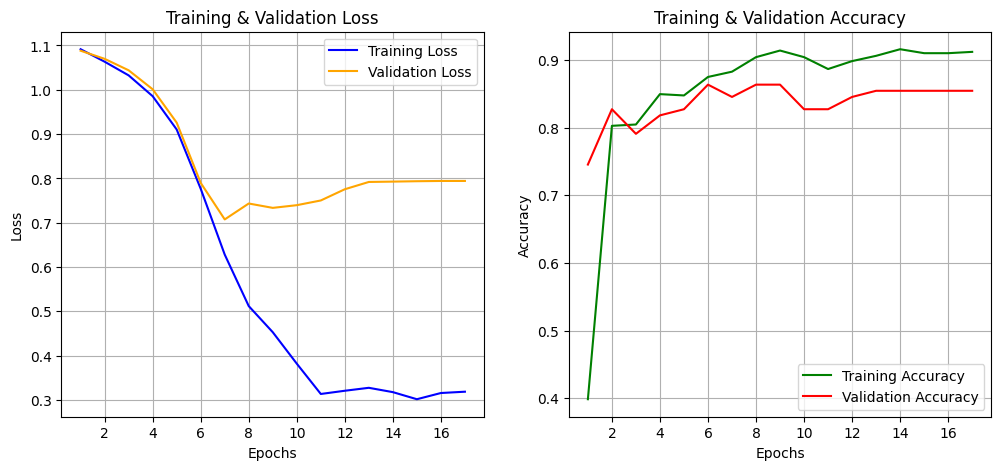

Test Accuracy: 0.9000, Precision: 0.9093, Recall: 0.9000, F1: 0.9040


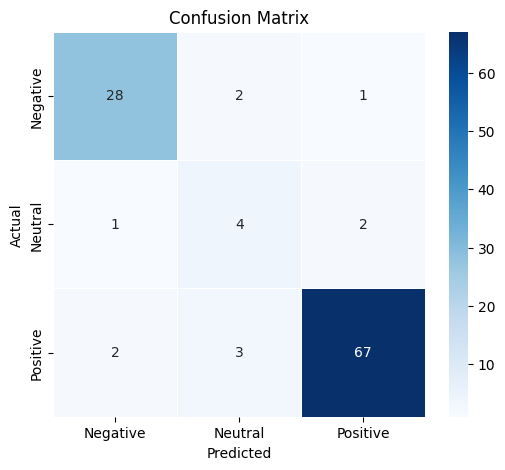

In [ ]:
# Train Model using BERT embeddings and store accuracy & loss history
model_bert = NLP_Sentiment_Model(768, 512, 3, dropout=0.3, use_glove=False)  # Using BERT embeddings, reduced dropout

train_losses, val_losses, train_accs, val_accs = train_model(
    model_bert, 
    (bert_train_emb, bert_train_lengths, y_train), 
    (bert_val_emb, bert_val_lengths, y_val), 
    lr=3e-5, patience=10, batch_size=32, epochs=40
)
# Plot Training and Validation Accuracy & Loss
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Evaluate the trained BERT model on the test set and plot confusion matrix
evaluate_model(model_bert, bert_test_emb, bert_test_lengths, y_test)

c:\Users\aishk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 1.0680, Train Acc: 0.5195 | Val Loss: 1.0792, Val Acc: 0.6636
Epoch 2 | Train Loss: 1.0480, Train Acc: 0.6562 | Val Loss: 0.8365, Val Acc: 0.8091
Epoch 3 | Train Loss: 0.8223, Train Acc: 0.8125 | Val Loss: 0.7875, Val Acc: 0.8727
Epoch 4 | Train Loss: 0.8007, Train Acc: 0.8594 | Val Loss: 0.6757, Val Acc: 0.8545
Epoch 5 | Train Loss: 0.7625, Train Acc: 0.8730 | Val Loss: 0.8753, Val Acc: 0.8636
Epoch 6 | Train Loss: 0.7137, Train Acc: 0.8770 | Val Loss: 0.8258, Val Acc: 0.8273
Epoch 7 | Train Loss: 0.7306, Train Acc: 0.8672 | Val Loss: 1.1579, Val Acc: 0.8636
Epoch 8 | Train Loss: 0.7888, Train Acc: 0.9082 | Val Loss: 1.0998, Val Acc: 0.8545
Epoch 9 | Train Loss: 0.7040, Train Acc: 0.9141 | Val Loss: 1.0395, Val Acc: 0.8545
Epoch 10 | Train Loss: 0.6384, Train Acc: 0.9121 | Val Loss: 1.0556, Val Acc: 0.8545
Epoch 11 | Train Loss: 0.6567, Train Acc: 0.9141 | Val Loss: 1.0529, Val Acc: 0.8545
Epoch 12 | Train Loss: 0.6479, Train Acc: 0.9141 | Val Loss: 1.0522, Val A

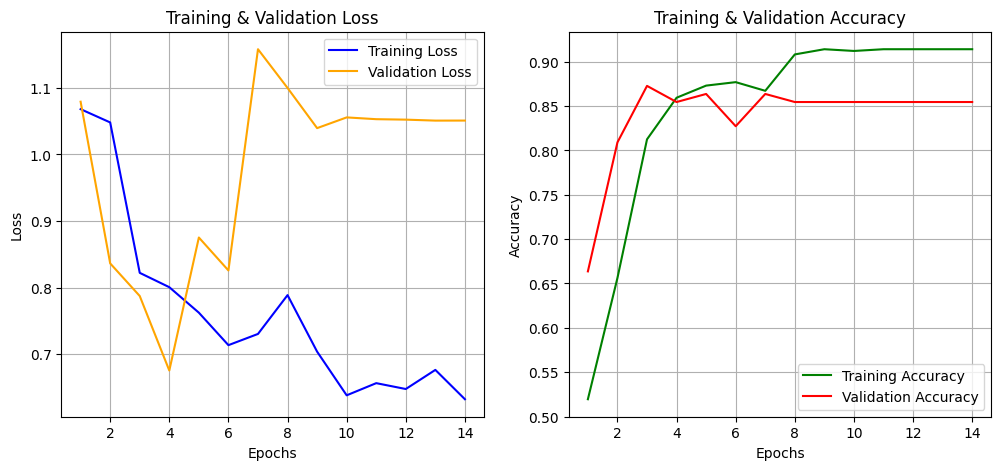

Test Accuracy: 0.8727, Precision: 0.8209, Recall: 0.8727, F1: 0.8426


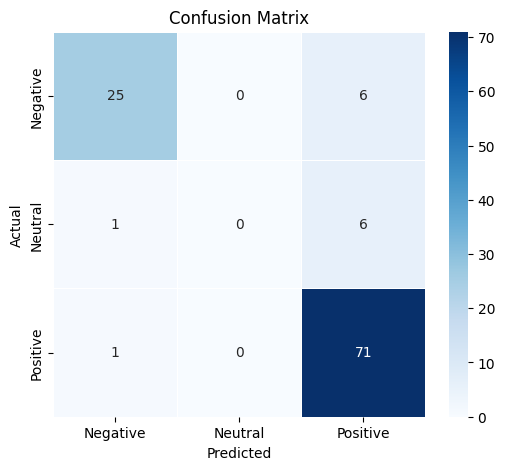

In [14]:
# Train Model using GloVe embeddings and store accuracy & loss history
model_glove = NLP_Sentiment_Model(100, 384, 3, dropout=0.5, use_glove=True)  # Using GloVe embeddings, higher dropout
train_losses, val_losses, train_accs, val_accs = train_model(
    model_glove, 
    (glove_train_emb, glove_train_lengths, y_train), 
    (glove_val_emb, glove_val_lengths, y_val), 
    lr=1.5e-4, patience=10, batch_size=8, epochs=40
)

# Plot Training and Validation Accuracy & Loss
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Evaluate the trained GloVe model on the test set and plot confusion matrix
evaluate_model(model_glove, glove_test_emb, glove_test_lengths, y_test)


## Conclusion

Performance Comparison of BERT and GloVe Models  

In this study, two different models were trained and evaluated for sentiment classification: BERT and GloVe. Both models performed well, but they exhibited key differences in terms of generalization, learning patterns, and overall effectiveness.  


####  BERT Model Performance  
**Test Accuracy:** 90.00%  
**Precision:** 90.93%  
**Recall:** 90.00%  
**F1-Score:** 90.40%  

- The BERT model outperformed the GloVe model in terms of accuracy, precision, recall, and F1-score.  
- It learned faster, with early stopping triggered at epoch 17, meaning it required fewer iterations to reach peak performance.  
- The validation accuracy stabilized around 86.36%, which indicates good generalization with minimal overfitting.  
- The model was able to capture context effectively, which is expected as BERT uses contextual embeddings, allowing it to understand word meanings better based on sentence context.  


####  GloVe Model Performance  
**Test Accuracy:** 87.27%  
**Precision:** 82.09%  
**Recall:** 87.27%  
**F1-Score:** 84.26%  

- The GloVe model performed well, achieving a respectable 87.27% accuracy, but slightly lower than BERT.  
- It required more training epochs (14 epochs) before early stopping was triggered, indicating a slower learning process compared to BERT.  
- The gap between training and validation accuracy suggests mild overfitting, meaning the model memorized patterns rather than fully generalizing.  
- Unlike BERT, GloVe embeddings are static, meaning words are represented with the same embedding in every context. This limits its ability to fully understand nuanced sentiment changes.  


####  Final comments  
- BERT outperforms GloVe in accuracy, precision, recall, and F1-score while learning faster with fewer epochs. Its contextual embeddings allow for better sentiment understanding, making it the preferred choice when computational resources are available.  
- GloVe is a good alternative for scenarios where efficiency is a priority, but its static embeddings limit contextual understanding, leading to slightly lower generalization performance.  
- BERT should be used when accuracy and nuanced text comprehension are critical, while GloVe is suitable for lightweight applications with limited computational capacity.

Thank you for the opportunity to explore and research this topic through this assignment. It has been a valuable learning experience, and We truly appreciate the insights gained.